In [1]:
# Goal -- do this better than I did the first time

# Basic imports
from numpy import loadtxt
import pandas as pd
import numpy as np
from math import ceil, pi
import random

# ML imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py # For model saving: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
from keras.models import load_model

# Metrics
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
tf.keras.backend.clear_session()


In [3]:
train = pd.read_csv('train.csv')
# change -1 to 0
train.loc[train.omega == -1, 'omega'] = 0

validation = pd.read_csv('validation.csv')
validation.loc[validation.omega == -1, 'omega'] = 0

test = pd.read_csv('test.csv')
test.loc[test.omega == -1, 'omega'] = 0

# Normalizing needs to be done based on train to maintain that validation and test are unseen datasets 

train['C0_norm'] = (train.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
test['C0_norm'] = (test.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
validation['C0_norm'] = (validation.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))

train['lam_norm'] = (train.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
test['lam_norm'] = (test.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
validation['lam_norm'] = (validation.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))

train['rad_norm'] = (train.rad - min(train.rad))/(max(train.rad) - min(train.rad))
test['rad_norm'] = (test.rad - min(train.rad))/(max(train.rad) - min(train.rad))
validation['rad_norm'] = (validation.rad - min(train.rad))/(max(train.rad) - min(train.rad))

train['pressure_norm'] = (train.pressure_dim - min(train.pressure_dim))/(max(train.pressure_dim) - min(train.pressure_dim))
test['pressure_norm'] = (test.pressure_dim - min(train.pressure_dim))/(max(train.pressure_dim) - min(train.pressure_dim))
validation['pressure_norm'] = (validation.pressure_dim - min(train.pressure_dim))/(max(train.pressure_dim) - min(train.pressure_dim))


print('train shape: ', train.shape)
print('validation shape: ', validation.shape)
print('test shape: ', test.shape)

train shape:  (26012, 119)
validation shape:  (3741, 119)
test shape:  (3147, 119)


In [4]:
omegas = train.where(train.omega == 1).dropna(how = 'all').reset_index(drop = 'True')
not_omegas = train.where(train.omega != 1).dropna(how = 'all').reset_index(drop = 'True')
print( 'Omegas: ', len(omegas), 'Non-omegas: ', len(not_omegas), 'Ratio: ', len(not_omegas)/len(omegas), 'Percent: ', 100*len(omegas)/len(not_omegas))

Omegas:  1513 Non-omegas:  24499 Ratio:  16.19233311302049 Percent:  6.175762276011266


In [5]:
# To deal with the imbalance in the dataset we will use only a subset of the non-omega curves in the training set (prop*length of omegas)
prop = 7
locs = random.sample(range(0, len(not_omegas)), ceil(prop*len(omegas)))
not_omegas_ = not_omegas.iloc[locs].reset_index(drop = 'True')
train_resampled = pd.concat([not_omegas_, omegas])
train_resampled = train_resampled.sample(frac = 1).reset_index(drop = 'True') # Shuffle it up and reset index
train = train_resampled

In [6]:
omegas = train.where(train.omega == 1).dropna(how = 'all').reset_index(drop = 'True')
not_omegas = train.where(train.omega != 1).dropna(how = 'all').reset_index(drop = 'True')
print( 'Omegas: ', len(omegas), 'Non-omegas: ', len(not_omegas), 'Ratio: ', len(not_omegas)/len(omegas))

Omegas:  1513 Non-omegas:  10591 Ratio:  7.0


In [7]:
# Build validation and train sets
features =['C0_norm', 'rad_norm','lam_norm', 'pressure_norm']

y_val = validation[['omega']] 
x_val = validation[features]
y_train = train[['omega']]
x_train = train[features]


In [8]:
# This model setup is based on this tutorial: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, x_train = x_train):
    in_dim = x_train.shape[-1]
    model = Sequential()
    model.add(Dense(10, input_dim=in_dim, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    keras.layers.Dropout(0.5),
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(), metrics=metrics)

    return model

In [9]:
es = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=200,
    mode='max',
    restore_best_weights=True)

mc = ModelCheckpoint(
    'best_model_classification_P.h5', 
    monitor='val_prc', 
    mode='max', 
    verbose=1,
    patience=200,
    save_best_only=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 12,271
Trainable params: 12,271
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_prc improved from -inf to 0.80076, saving model to best_model_classification_P.h5

Epoch 00002: val_

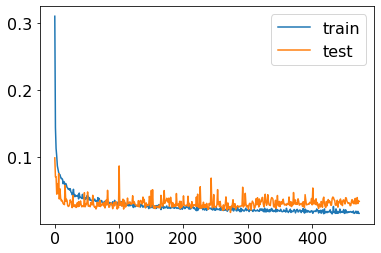

In [10]:
model = make_model()
model.summary()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=4000, batch_size=32, verbose=0, callbacks=[es, mc])

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# predictions = model.predict(x_val)
# rounded = [round(x[0]) for x in predictions]

In [11]:
best_model = load_model('best_model_classification_P.h5')
# summarize model.
best_model.summary()

predictions = best_model.predict(x_val)
rounded = [round(x[0]) for x in predictions]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 12,271
Trainable params: 12,271
Non-trainable params: 0
_________________________________________________________________


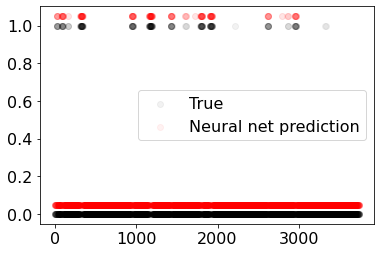

In [12]:
plt.scatter(np.arange(0,len(y_val)), y_val, c = 'black', alpha = .05, label = 'True')
plt.scatter(np.arange(0,len(y_val)), np.array(rounded) + .05, c = 'red', alpha = .05, label = 'Neural net prediction')
plt.legend()


In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.show()
    #plt.savefig('ConfusionMatrix.png', bbox_inches="tight")

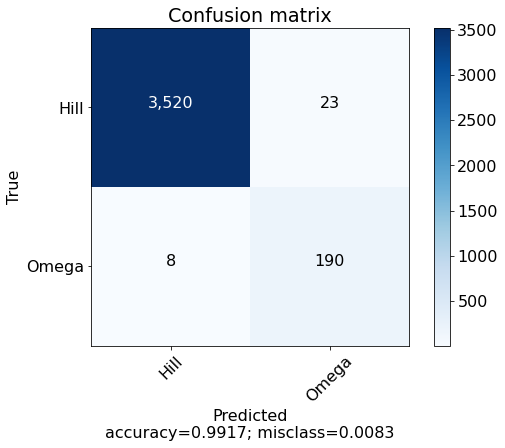

In [14]:
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_val, rounded),
                          ['Hill', 'Omega'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)
#plt.savefig('ConfusionMatrix.png', bbox_inches="tight")

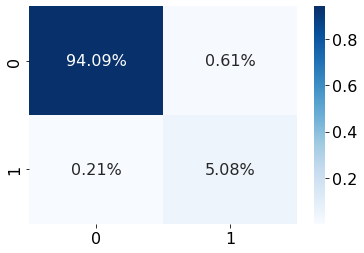

In [15]:
cf_matrix = sklearn.metrics.confusion_matrix(y_val, rounded)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')



AUC: 0.999


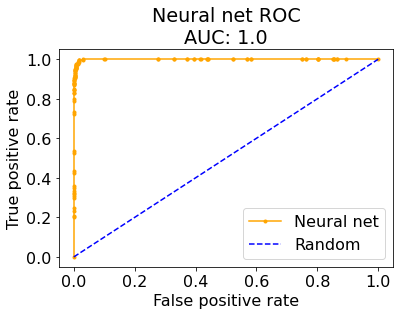

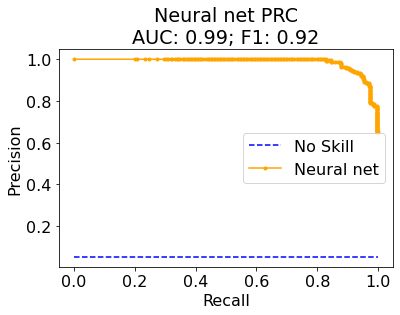

In [16]:
# ROC is a standard way to evaluate model performance, and AUC-ROC is a standard way to compare models
# PRC however is the way to go for imbalanced data:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/
# https://www.youtube.com/watch?v=4jRBRDbJemM
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

# Calculate ROC curve
fpr1, tpr1, thresh1 = roc_curve(y_val, predictions, pos_label=1)

# The baseline for an ROC curve is random guesses (tpr = fpr)
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

# Calculate AUC for ROC
auc = sklearn.metrics.roc_auc_score(y_val, predictions)
print('AUC: %.3f' % auc)

# Plotting
plt.plot(fpr1, tpr1, marker='.', color='orange', label='Neural net')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural net ROC\n' + 'AUC: ' + str(round(auc, 2)))
plt.legend()

plt.show()

# PRC: Better for imbalanced classification like this problem

# Calculate precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_val, predictions)

# No skill is just P / (P + N)
no_skill = len(y_val[y_val==1].dropna(how = 'all')) / len(y_val)

# Calculate auc and F1 metrics
auc = sklearn.metrics.auc(recall, precision)
f1 = sklearn.metrics.f1_score(y_val, rounded)

# Plotting
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color = 'blue')
plt.plot(recall, precision, marker='.', label='Neural net', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Neural net PRC\n' +'AUC: ' + str(round(auc, 2)) + '; F1: ' + str(round(f1, 2)))
plt.legend()

In [17]:
# Create the grid of parameters overwhich to define a phase diagram using the ML model 
R0 = 20
loop_number = 30
C0_ran = np.linspace(0, .07, loop_number)*R0*(-1) # We need to non-dimensionalize consistently since I recorded non-dimensionalized C0 instead of dimensional 
grid_params_pre = pd.read_csv('Test_parameter_combos_pressure.csv')

grid_params = []
for i in grid_params_pre.index:
    for j in C0_ran: 
        grid_params.append([j, grid_params_pre.rad.iloc[i], grid_params_pre.lam_dim.iloc[i], grid_params_pre.pressure_dim.iloc[i]])

grid_params = pd.DataFrame(grid_params, columns=['C0', 'rad', 'lam_dim', 'pressure_dim'])

# Code to normalize features between 0 and 1
grid_params['C0_norm'] = (grid_params.C0*-1 - min(grid_params.C0*-1))/(max(grid_params.C0*-1) - min(grid_params.C0*-1))
grid_params['lam_norm'] = (grid_params.lam_dim - min(grid_params.lam_dim))/(max(grid_params.lam_dim) - min(grid_params.lam_dim))
grid_params['rad_norm'] = (grid_params.rad - min(grid_params.rad))/(max(grid_params.rad) - min(grid_params.rad))
grid_params['pressure_norm'] = (grid_params.pressure_dim - min(grid_params.pressure_dim))/(max(grid_params.pressure_dim) - min(grid_params.pressure_dim))
grid_params.head()



,C0,rad,lam_dim,pressure_dim,C0_norm,lam_norm,rad_norm,pressure_norm
0,-0.000000,25.0,0.003,0.0,0.000000,0.0,0.0,0.0
1,-0.048276,25.0,0.003,0.0,0.034483,0.0,0.0,0.0
2,-0.096552,25.0,0.003,0.0,0.068966,0.0,0.0,0.0
3,-0.144828,25.0,0.003,0.0,0.103448,0.0,0.0,0.0
4,-0.193103,25.0,0.003,0.0,0.137931,0.0,0.0,0.0


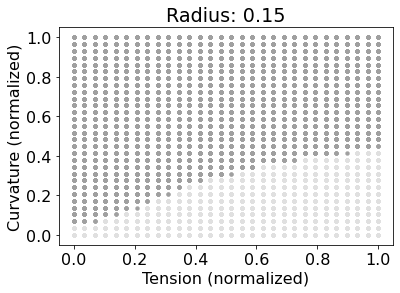

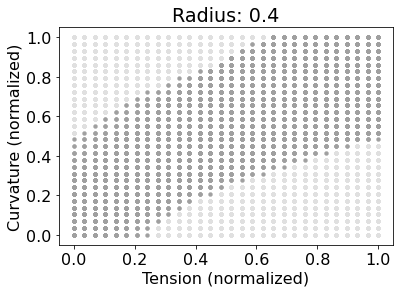

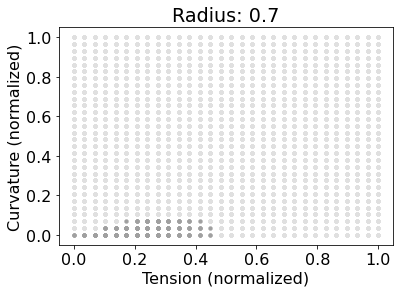

In [18]:
# Create phase diagrams based on ML prediction using specified patch radii (the values over which the script loops)
predictions = model.predict(x_val)
rounded = [round(x[0]) for x in predictions]

for rad_val in [.15, .4, .7]:
    grid_params_sub = grid_params[features].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
    grid_pred = model.predict(grid_params_sub.to_numpy())
    grid_pred_rounded = [round(x[0]) for x in grid_pred]
    results = grid_params_sub
    results['preds'] = grid_pred_rounded

    results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
    Curv_ten_rad = plt.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

    results_omegas = results.where(results.preds == 1).dropna(how = 'all')
    plt.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
    plt.xlabel('Tension (normalized)')
    plt.ylabel('Curvature (normalized)')
    plt.title('Normalized radius: ' + str(rad_val))
    #plt.savefig('NN_Phasemap_rad15.png', bbox_inches='tight')
    plt.show()


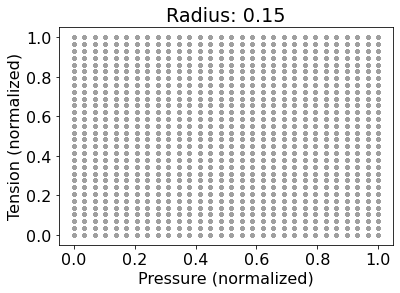

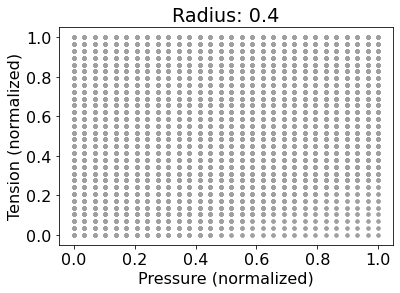

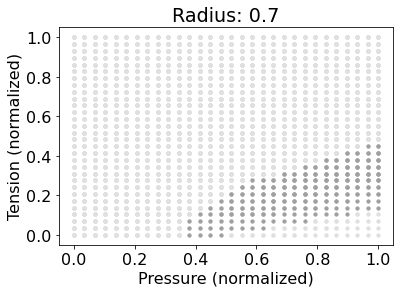

In [19]:
# Create phase diagrams based on ML prediction using specified patch radii (the values over which the script loops)
for rad_val in [.15, .4, .7]:
    grid_params_sub = grid_params[features].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
    grid_pred = model.predict(grid_params_sub.to_numpy())
    grid_pred_rounded = [round(x[0]) for x in grid_pred]
    results = grid_params_sub
    results['preds'] = grid_pred_rounded

    results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
    Curv_ten_rad = plt.scatter(results_omegas.pressure_norm, results_omegas.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

    results_omegas = results.where(results.preds == 1).dropna(how = 'all')
    plt.scatter(results_omegas.pressure_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
    
    plt.xlabel('Pressure (normalized)')
    plt.ylabel('Tension (normalized)')
    plt.title('Normalized radius: ' + str(rad_val))
    #plt.savefig('NN_Phasemap_rad15.png', bbox_inches='tight')
    plt.show()



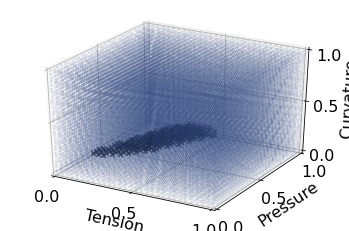

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

temp = train

for i in results.index:  # np.random.choice(results.index, 2000, replace=False)
    x = results.iloc[i].lam_norm
    y = results.iloc[i].pressure_norm 
    z = results.iloc[i].C0_norm
    
    if results.iloc[i].preds == 1:
        m = 'x'
        col = 'black'
        alph = .7
    else:
        m = '.'
        col = "#3b528b"
        alph = .1
    ax.scatter(x, y, z, marker=m, c = col, alpha = alph)

ax.set_xlabel('Tension')
ax.set_ylabel('Pressure')
ax.set_zlabel('Curvature')


ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)

plt.locator_params(axis="x", nbins=2)
plt.locator_params(axis="y", nbins=2)
plt.locator_params(axis="z", nbins=2)

#plt.savefig('3D_trainset.pdf', bbox_inches="tight")

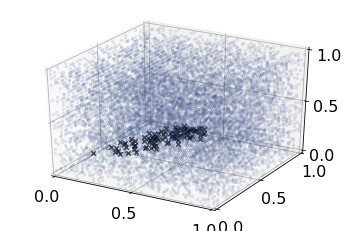

In [34]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

temp = train

for i in np.random.choice(results.index, 10000, replace=False):
    x = results.iloc[i].lam_norm
    y = results.iloc[i].pressure_norm 
    z = results.iloc[i].C0_norm
    
    if results.iloc[i].preds == 1:
        m = 'x'
        col = 'black'
        alph = .7
    else:
        m = '.'
        col = "#3b528b"
        alph = .1
    ax.scatter(x, y, z, marker=m, c = col, alpha = alph)

ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)

plt.locator_params(axis="x", nbins=2)
plt.locator_params(axis="y", nbins=2)
plt.locator_params(axis="z", nbins=2)

plt.savefig('3D_NN_preds.png', bbox_inches="tight")